### Settings
- $\Omega$ is the unit ball $\{x \in \mathbb{R}^2 : \|x\| \le 1\}$
- $Z$ is the uniform rectangular grid of $\Omega$

In [1]:
# required packages: numpy, cvxpy, matplotlib
# https://numpy.org/
# https://www.cvxpy.org/
# https://matplotlib.org/

import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt
import itertools
import os

# to save figures
if not os.path.isdir('figs'):
    os.makedirs('figs')

# minimal selection algorithm
def minimal_selection(X, Z, VX, VZ):
    # X (m, d) or (m,)
    # Z (n, d) or (n,)
    # VX (m,)
    # VZ (n,)

    if np.ndim(X) == 1:
        X = X.reshape(-1, 1) # to (m, 1)
        Z = Z.reshape(-1, 1) # to (n, 1)
    
    m, d = np.shape(X)
    Xi = np.zeros((m, d))
    feas = np.ones(m, dtype=bool)
    status = []
    for j in range(m):
        xi = cp.Variable(d)
        obj = cp.Minimize(cp.sum_squares(xi))
        constraints = [VX[j] - VZ <= (X[j, :] - Z) @ xi]
        prob = cp.Problem(obj, constraints)
        prob.solve(solver=cp.ECOS)
        status.append(prob.status)

        if prob.status in ["infeasible", "infeasible_inaccurate"]:
            Xi[j, :] = np.zeros(d)
            feas[j] = 0
        else:
            Xi[j,:] = xi.value

    return Xi, status, feas

# minimal selection or exploration algorithm
def ms_or_exploration(X, Z, VX, VZ, eta):
    # X (m, d) or (m,)
    # Z (n, d) or (n,)
    # VX (m,)
    # VZ (n,)

    if np.ndim(X) == 1:
        X = X.reshape(-1, 1) # to (m, 1)
        Z = Z.reshape(-1, 1) # to (n, 1)
    
    m, d = np.shape(X)
    Xi_scaled = np.zeros((m, d))
    feas = np.ones(m, dtype=bool)
    status = []
    for j in range(m):
        xi = cp.Variable(d)
        obj = cp.Minimize(cp.sum_squares(xi))
        constraints = [VX[j] - VZ <= (X[j, :] - Z) @ xi]
        prob = cp.Problem(obj, constraints)
        prob.solve(solver=cp.ECOS)
        status.append(prob.status)

        if prob.status in ["infeasible", "infeasible_inaccurate"]:
            scale = np.sqrt(eta * np.max(np.maximum(VX[j] - VZ, 0)) / d)
            Xi_scaled[j, :] = scale * np.random.randn(d)
            feas[j] = 0
        else:
            Xi_scaled[j,:] = eta * xi.value

    return Xi_scaled, status, feas

# projection operator
def projection(X, D):
    # X (m, d) or (m,)
    # for each row x of X
    # if ||x|| > D
    #   x <- x / ||x|| * D

    if np.ndim(X) == 1:
        X = X.reshape(-1, 1) # to (m, 1)
    Xnorm = np.linalg.norm(X, axis=1)
    ind = Xnorm > D
    X[ind, :] = X[ind, :] / Xnorm[ind, np.newaxis] * D
    
    return X

def uniform_grid(a, b, k, d):
    z = np.linspace(a, b, k)
    Z = np.array(list(itertools.product(z, repeat=d))) # (k^d, d)

    return Z


# samplers
def UnitSphereSampler(d, n):
    # uniformly sample from ||x|| = 1

    x = np.random.randn(n, d)
    x_norm = np.linalg.norm(x, 2, axis=1)
    
    if np.min(x_norm) == 0:

        return UnitSphereSampler(d, n)
    else:

        return np.divide(x, x_norm[:,np.newaxis]) 

def UnitBallSampler(d, n):
    # uniformly sample from ||x|| <= 1
    
    x = UnitSphereSampler(d, n)
    
    return np.multiply(x, np.random.uniform(size=(n, 1)))


def UnitBallGrid(d, k):
    # 1. uniform grid of [-1, 1]^d 
    # 2. choose a subset contained in the unit ball

    z = np.linspace(-1.0, 1.0, k)
    Z = np.array(list(itertools.product(z, repeat=d))) # (k^d, d)
    Znorm = np.linalg.norm(Z, axis=1)
    ind = Znorm <= 1.0

    return Z[ind, :]


### Convex case
$V_t(x) = \|x - u_t\|^2$, where $u_t$ is the loaction of some moving particle

In [2]:
np.random.seed(23)

d = 2
k = 33
Z = UnitBallGrid(d, k)
n = np.shape(Z)[0] # n = 797
m = 10
X_init = UnitBallSampler(d, m) # initial decision points

T = 20
eta = 0.2

# results 
Xs = []
Xis = []
VXs = np.zeros((m, T))
VZs = np.zeros((n, T))
OBJ = np.zeros(T)
STATUS = []
FEAS = np.ones((m, T), dtype=bool)

for t in range(T+1):
    if t == 0:
        X = X_init
    else: 
        Xi, status, feas = minimal_selection(Xs[t-1], Z, VXs[:,t-1], VZs[:,t-1])
        FEAS[:,t-1] = feas
        STATUS.append(status)
        OBJ[t-1] = np.sum(Xi**2) / m
        Xis.append(Xi)
        X = Xs[t - 1] - eta * Xi 
        X = projection(X, 1.0)

    Xs.append(X)
    
    if t == T:
        break

    # V_t(x) = ||x - u_t||^2, where u_t moves towards north east
    if t == 0:
        u = -np.ones(d) / np.sqrt(d) # initial location of the particle
    else:
        u = u + np.ones(d) * 0.15 # towards north east
        
    VX = np.sum((X - u)**2, axis=1)
    VZ = np.sum((Z - u)**2, axis=1)

    VXs[:,t] = VX
    VZs[:,t] = VZ

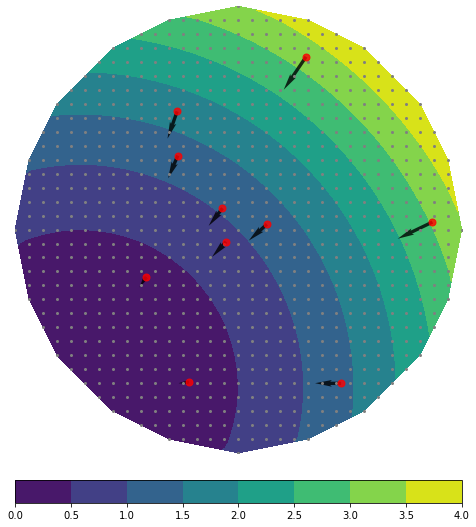

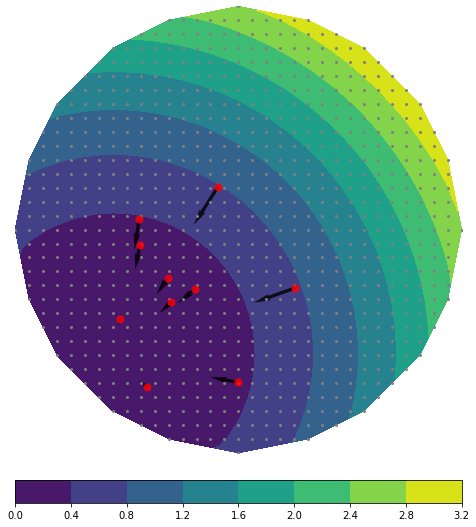

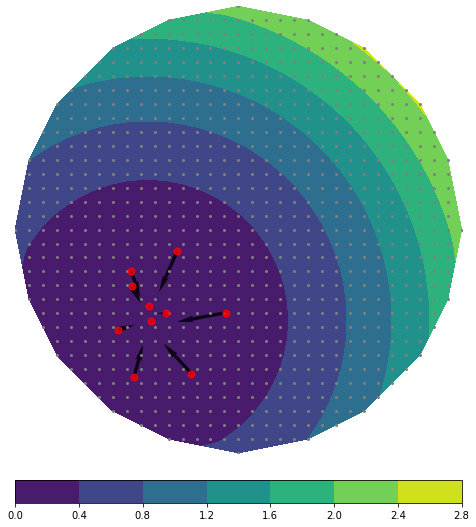

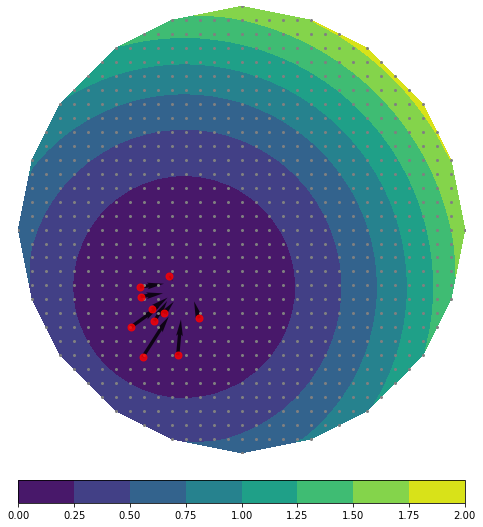

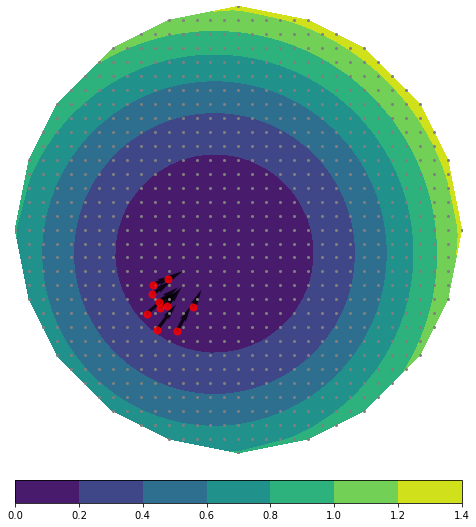

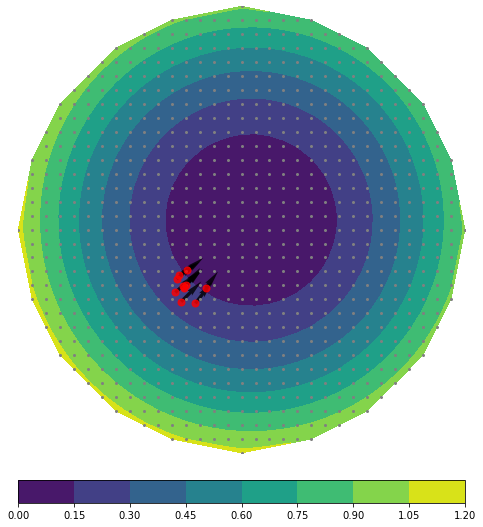

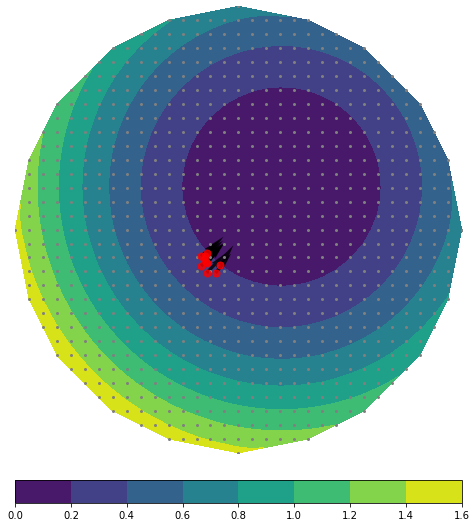

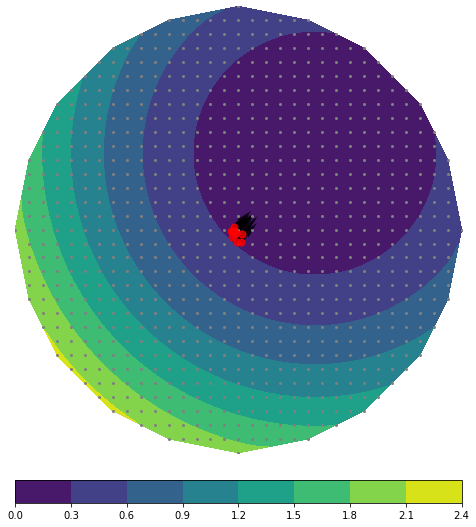

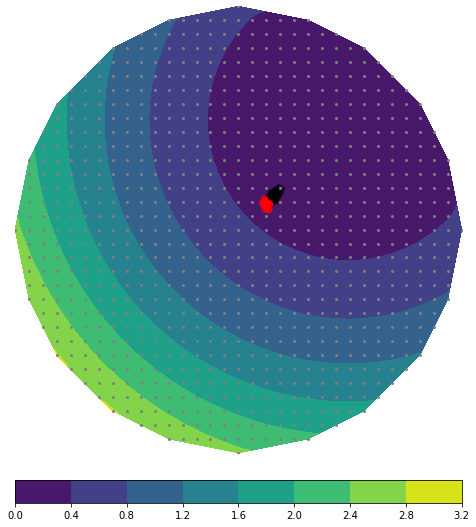

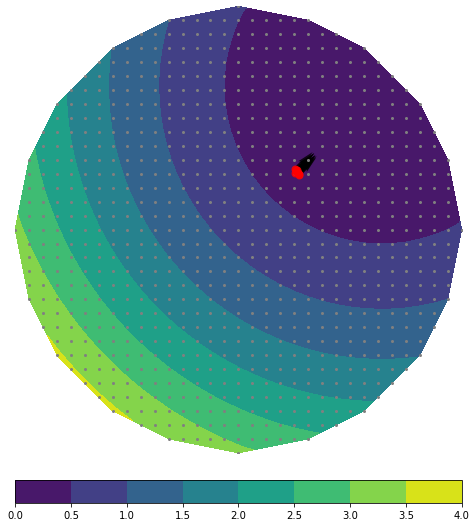

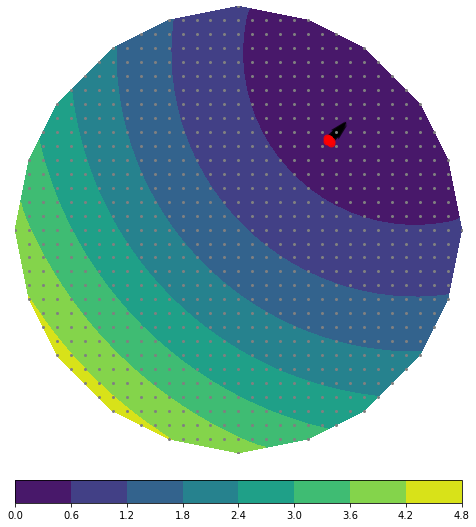

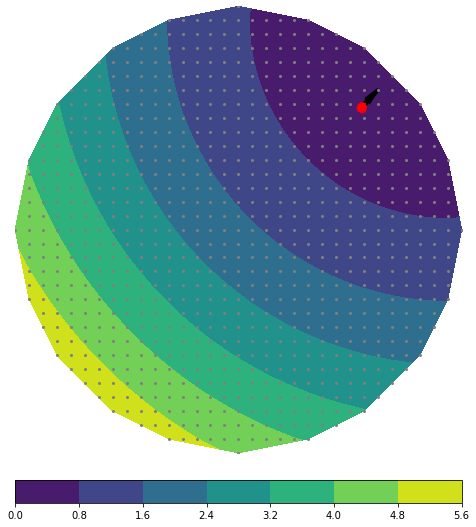

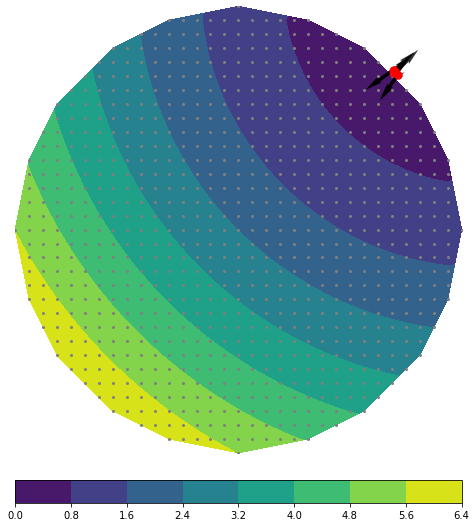

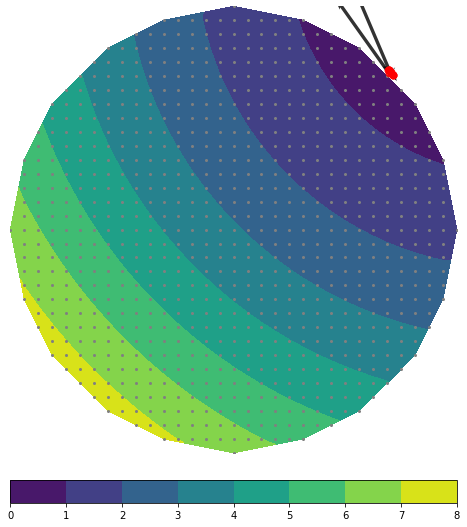

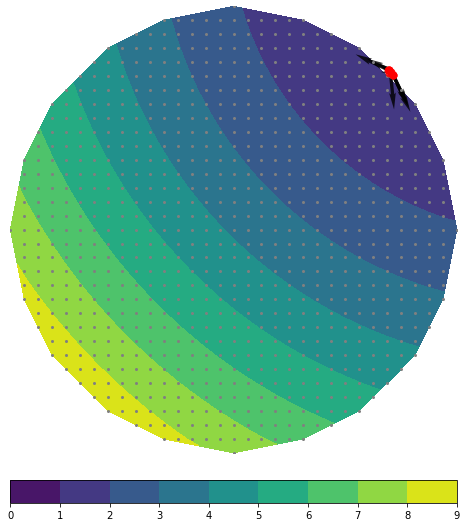

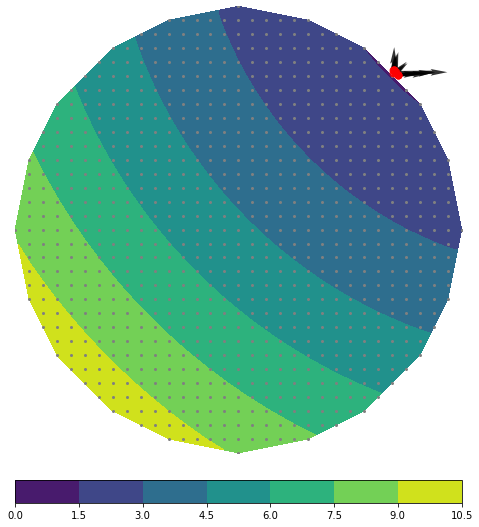

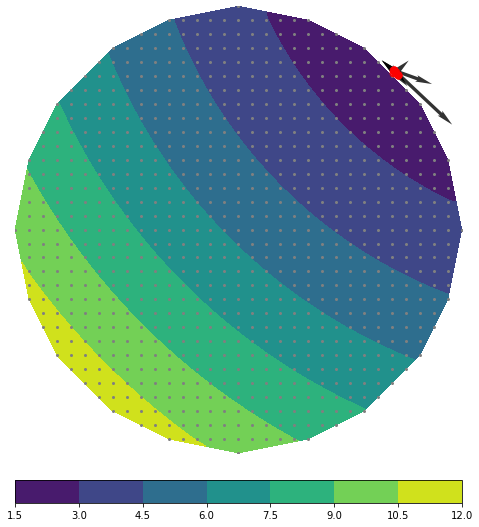

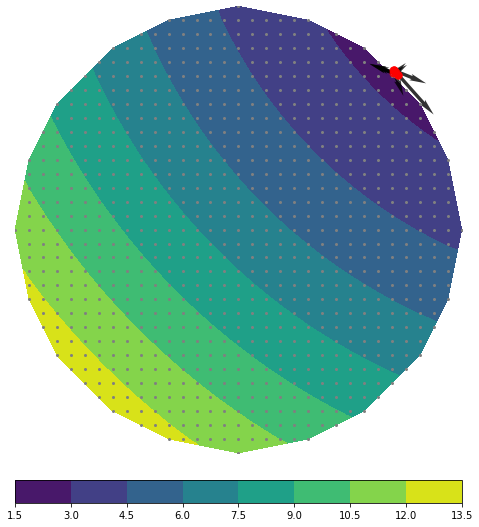

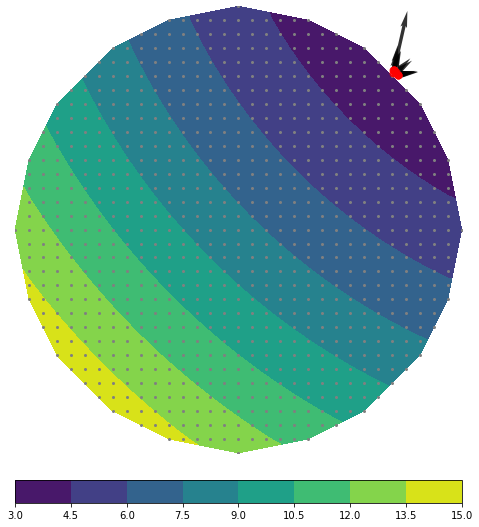

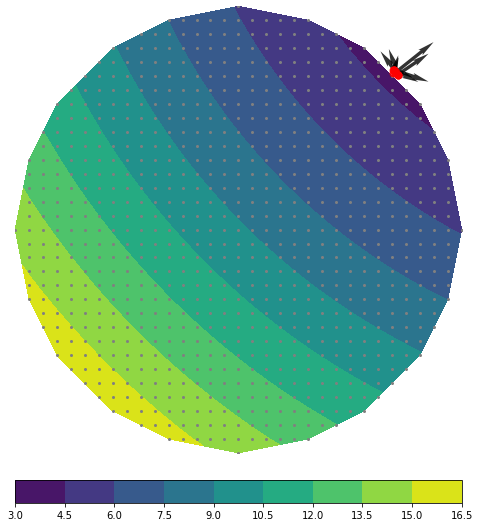

In [3]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

for t in range(T):
    fig, ax = plt.subplots(figsize=(8,10))
    ax.plot(Z[:,0], Z[:,1], 'o', markersize=2, color='grey')
    ax.plot(Xs[t][:,0], Xs[t][:,1], 'o', color='red', alpha=0.8, markersize=7, label="$x_j^t$")
    tcf = ax.tricontourf(Z[:,0], Z[:,1], VZs[:,t])
    ax.set_aspect('equal', 'box')
    ax.quiver(Xs[t][:,0], Xs[t][:,1], -Xis[t][:,0], -Xis[t][:,1], color='black', alpha=0.8, units='inches', headwidth=2)
    ax.axis('off')
    axins = inset_axes(ax,
                        width="100%",  
                        height="5%",
                        loc='lower center',
                        borderpad=-5
                    )
    fig.colorbar(tcf, cax=axins, orientation="horizontal")
    plt.savefig(f'figs/convex{t+1}.pdf')

### Non-convex case
$V_t(x) = \min(\|x - u_t\|^2, \|x - v_t\|^2)$, where $u_t$ and $v_t$ are the locations of two moving particles

In [4]:
np.random.seed(23)

d = 2
k = 33
Z = UnitBallGrid(d, k)
n = np.shape(Z)[0] # n = 797
m = 10
X_init = UnitBallSampler(d, m) # initial decision points

T = 20
eta = 0.05

# results 
Xs = []
Xis_scaled = []
VXs = np.zeros((m, T))
VZs = np.zeros((n, T))
STATUS = []
FEAS = np.ones((m, T), dtype=bool)

for t in range(T+1):
    if t == 0:
        X = X_init
    else: 
        Xi_scaled, status, feas = ms_or_exploration(Xs[t-1], Z, VXs[:,t-1], VZs[:,t-1], eta)
        FEAS[:,t-1] = feas
        STATUS.append(status)
        Xis_scaled.append(Xi_scaled)
        X = Xs[t - 1] - Xi_scaled
        X = projection(X, 0.98) # 0.98 instead of 1 for better visualization 

    Xs.append(X)
    
    if t == T:
        break

    # V_t(x) = min(||x - u_t||^2, ||x-v_t||^2), where u_t, v_t move separately
    if t == 0:
        u = v = -np.ones(d) / np.sqrt(d) # initial location of the particles
    else:
        u = u + np.array([1.5, 1.0]) * 0.11 # moving along (1.5, 1)
        v = v + np.array([1.0, 1.5]) * 0.11 # moving along (1, 1.5)
        
    VX = np.minimum(np.sum((X - u)**2, axis=1), np.sum((X - v)**2, axis=1))
    VZ = np.minimum(np.sum((Z - u)**2, axis=1), np.sum((Z - v)**2, axis=1))

    VXs[:,t] = VX
    VZs[:,t] = VZ


c:\Users\yoonh\miniconda3\envs\convex\lib\site-packages\cvxpy\problems\problem.py:1297: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  "Solution may be inaccurate. Try another solver, "


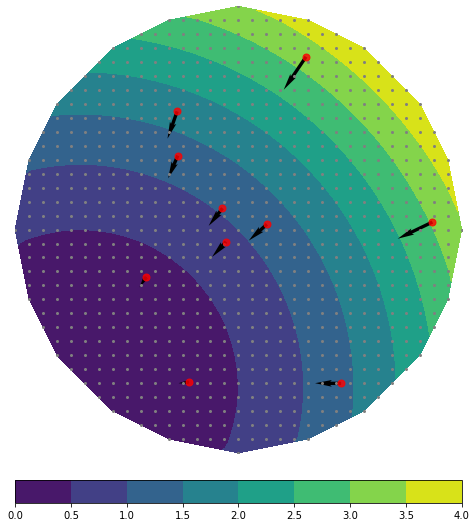

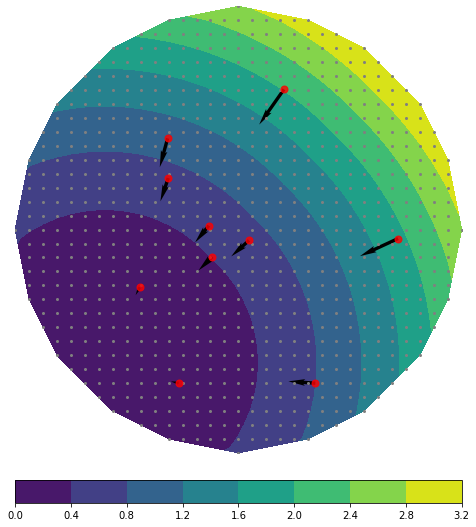

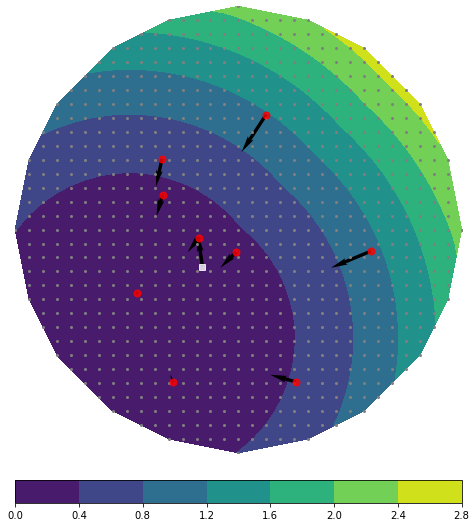

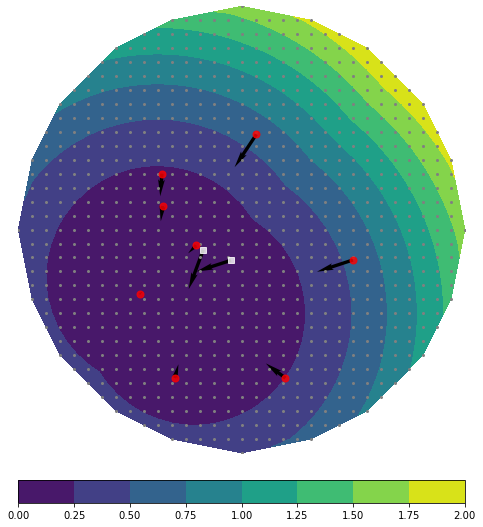

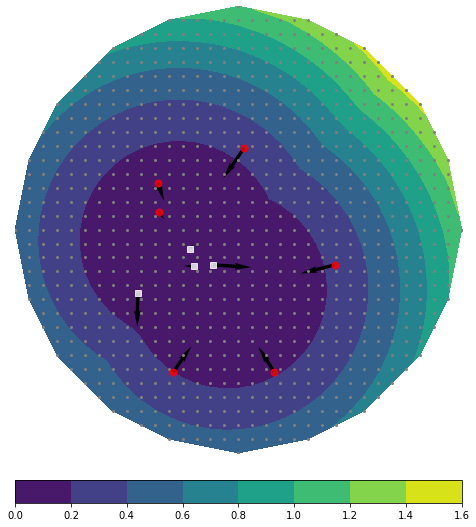

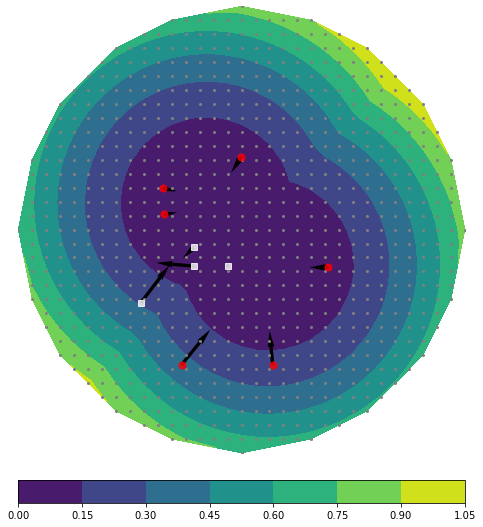

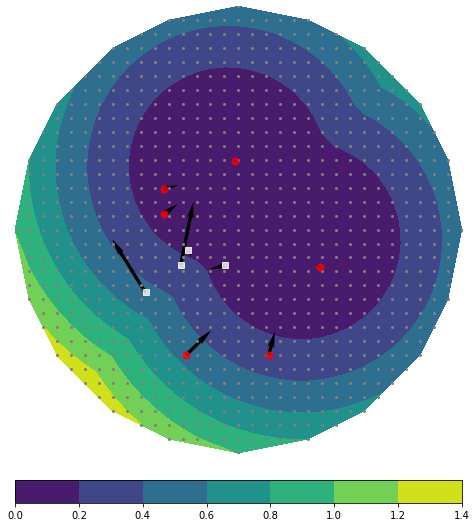

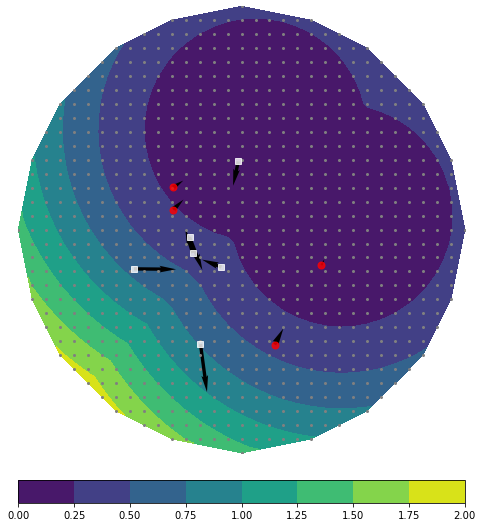

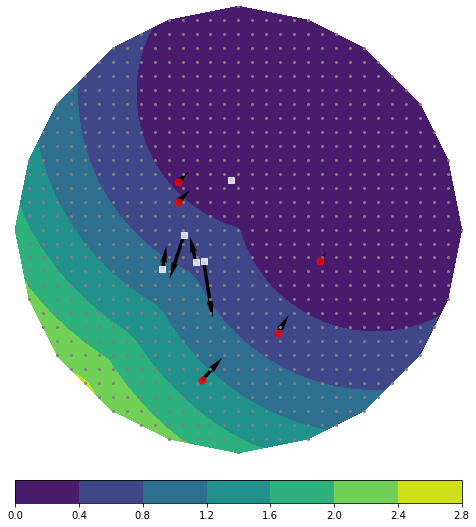

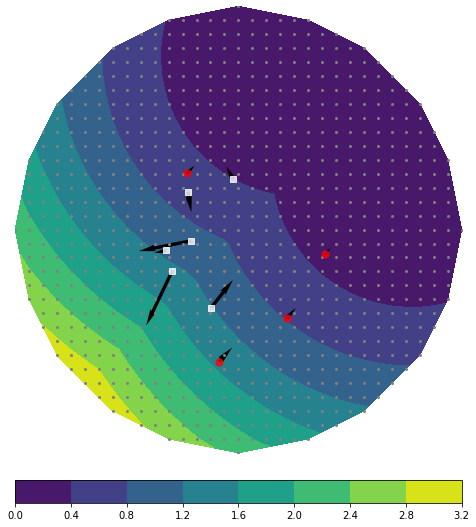

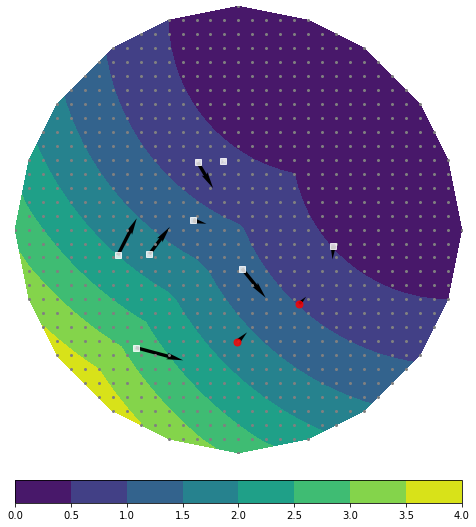

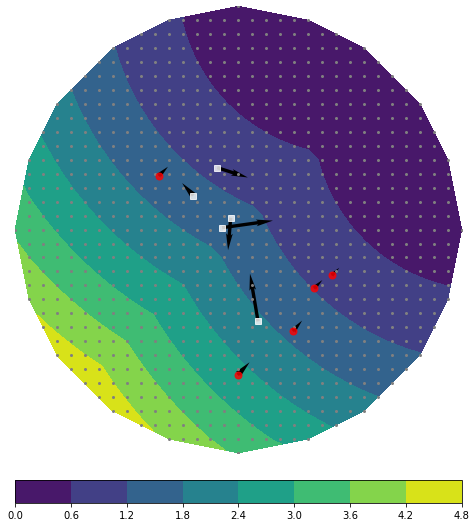

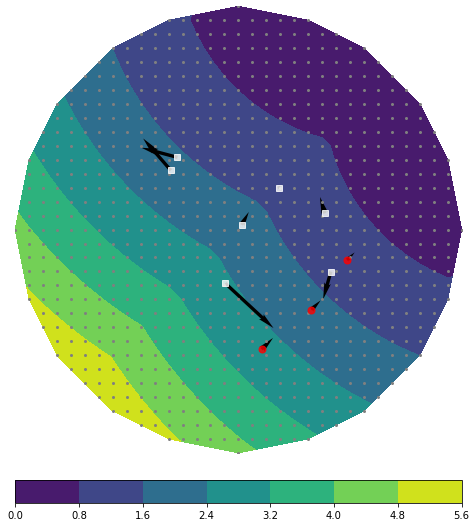

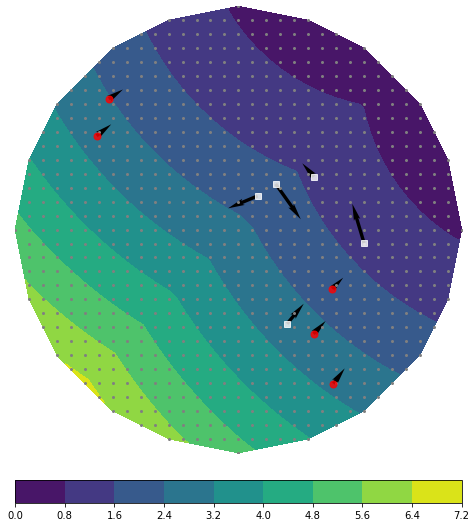

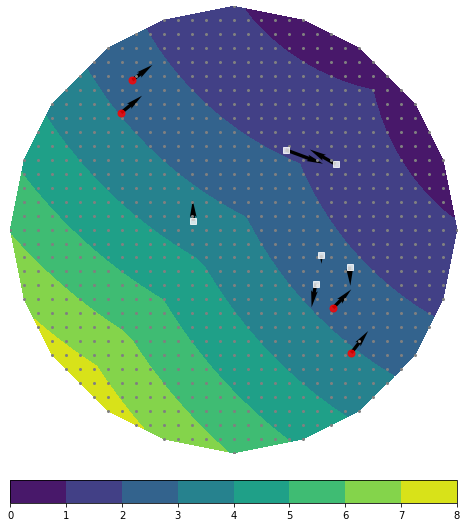

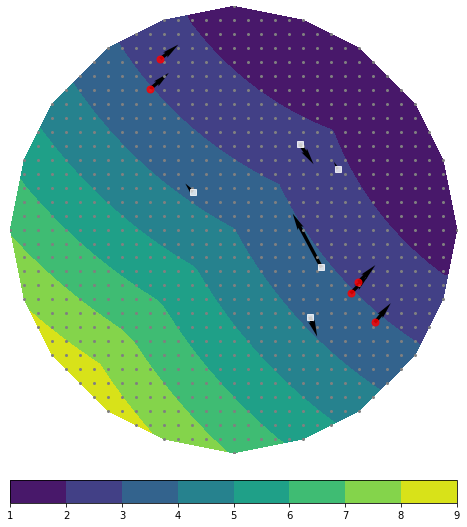

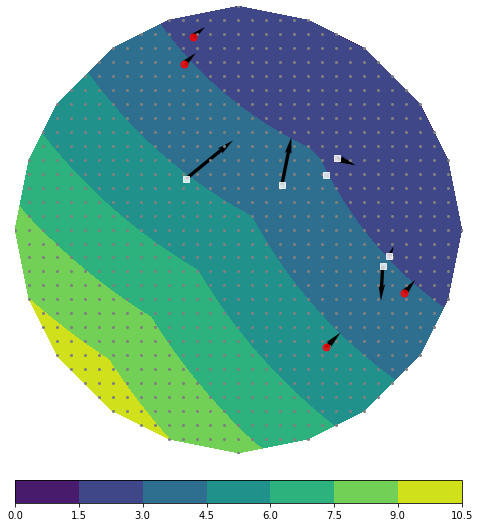

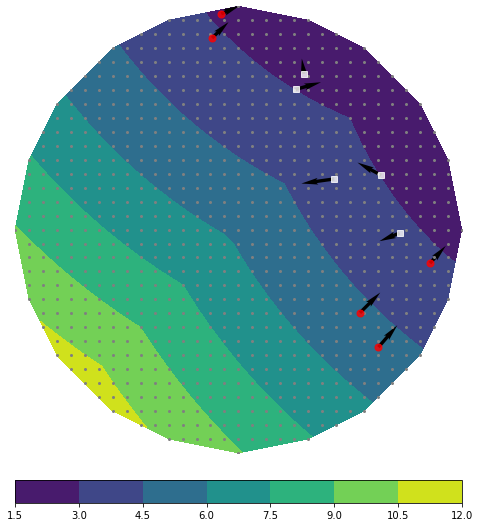

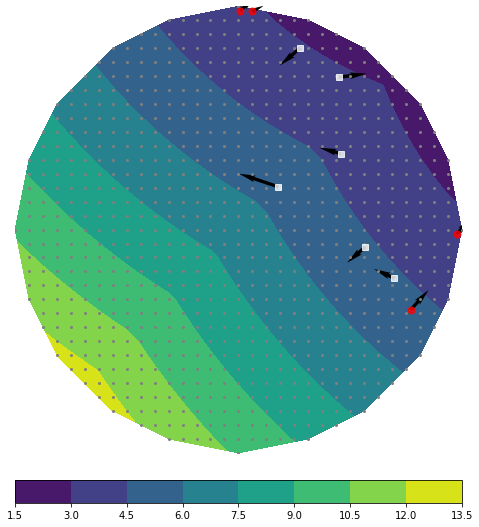

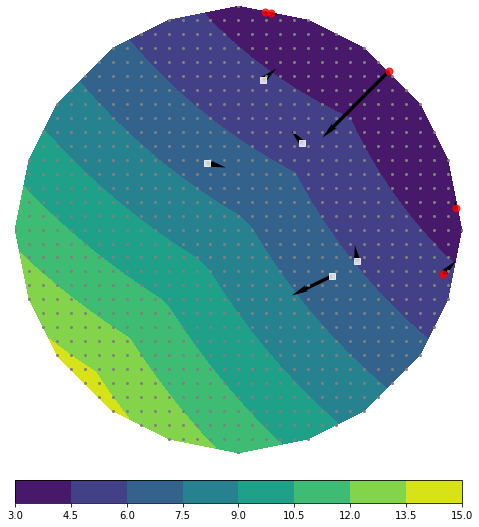

In [5]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

for t in range(T):
    fig, ax = plt.subplots(figsize=(8,10))
    ax.plot(Z[:,0], Z[:,1], 'o', markersize=2, color='grey')

    if sum(FEAS[:,t]) > 0:
        ax.plot(Xs[t][FEAS[:,t],0], Xs[t][FEAS[:,t],1], 'o', color='red', alpha=0.8, markersize=7, label="$x_j^t (feasible)$")

    if np.sum(~FEAS[:,t]) > 0:
        ax.plot(Xs[t][~FEAS[:,t],0], Xs[t][~FEAS[:,t],1], 's', color='white', alpha=0.8, markersize=6, label="$x_j^t (infeasible)$")

    tcf = ax.tricontourf(Z[:,0], Z[:,1], VZs[:,t])
    ax.set_aspect('equal', 'box')
    ax.quiver(Xs[t][:,0], Xs[t][:,1], -Xis_scaled[t][:,0], -Xis_scaled[t][:,1], color='black', units='inches', headwidth=2)
    ax.axis('off')
    axins = inset_axes(ax,
                        width="100%",  
                        height="5%",
                        loc='lower center',
                        borderpad=-5
                    )
    fig.colorbar(tcf, cax=axins, orientation="horizontal")
    plt.savefig(f'figs/nonconvex{t+1}.pdf')